In [10]:
%matplotlib ipympl

import numpy as np
import h5py
import matplotlib.pyplot as plt

# import boost_histogram as bh
# import hist
import mplhep

from geohelper import geohelper

In [19]:
from sklearn.neighbors import NearestNeighbors

In [20]:

class neighbor_finder:
    """Find out nearest neighbors
    """
    def __init__(self):
        self.points = np.array([])
        self.finder = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
    def load_points(self, points):
        self.points = points
    def find_k_neighbors(self, points, k):
        if k > 1:
            self.finder = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
        elif k <=0:
            raise NotImplementedError("k must be non-negative")
        self.finder.fit(self.points)
        distances, indices = self.finder.kneighbors(points)
        return distances, indices

In [11]:
### all Bern module data has been uploaded to NERSC - a NERSC account is not needed to access
### see this link for click-downloadable files: https://portal.nersc.gov/project/dune/data/Module1/TPC12/dataRuns/packetData/
file2306='packet_2022_02_10_22_58_34_CET.h5'
ftimestamp=file2306.split("/")[-1].split('2022_02_10_')[-1].split("_CET")[0]

In [12]:
f=h5py.File(file2306,'r')
io_group_mask=f['packets']['io_group']==1 # selects packets from a specific TPC
packets=f['packets'][io_group_mask]
sync_mask=((packets['packet_type']==6)&(packets['trigger_type']==83)) # selects SYNC packets that are externally generated
print(sync_mask.shape)
sync_idcs=np.argwhere(sync_mask).flatten()
message_groups=np.split(packets, sync_idcs) # partition the packet dataset by sync packet index
print(len(message_groups),' packet groups partitioned by sync packets')

(48479011,)
1201  packet groups partitioned by sync packets


In [13]:
def plot_events(sync_group, counter,threshold=500):
    helper = geohelper()
    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')
    
    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
    ax[0].stairs(counts, xbins)
    ax[0].set_xlabel('Timestamp')
    ax[0].set_ylabel('Packet count')
    ax[0].set_ylim(0,2e3)
    
    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)
    for i in range(len(physics_bins)): 
        if i!=counter: ax[0].axvline(x=physics_bins[i]*bin_width, alpha=0.5, color='k', linestyle='dashed') # mark all bins exceeding threshold
        if i==counter: ax[0].axvline(x=physics_bins[i]*bin_width, alpha=0.5, color='r', linestyle='dashed') # mark in red bin corresponding to scatter plot hits
    ax[0].axhline(y=threshold, color='g', linestyle='dashed') # denote packet count threshold to categorize as event

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp

    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']
    dataword = hits['dataword'] # ADC value
    print(len(dataword),' hits in event')

    # correlate hardware ID to geometry information to find (x,y) position of hits
    x=[]; y=[]
    for i in range(len(tile_id)):
        xc,yc = helper.find_xy(tile_id[i], chip_id[i], channel_id[i])
        x.append(xc); y.append(yc)
    
    ax[1].scatter(x,y,s=1); ax[1].set_xlabel('X [mm]'); ax[1].set_ylabel('Y [mm]')
    ax[2].scatter(timestamp,y,s=1); ax[2].set_ylabel('Y [mm]'); ax[2].set_xlabel(r'Timestamp [0.1 $\mu$s]')

    ax[2].set_xlabel(r'Timestamp [0.1 $\mu$s]')

    for i in range(1,3): ax[i].set_ylim(-600,600)

    
    plt.tight_layout()

    plot_name='sync_'+str(sync_group)+'_threshold_'+str(threshold)+'_event_'+str(counter)+'_timestamp_'+str(ftimestamp)+'.png'
    #plt.savefig(plot_name)

In [14]:
def plot_events_3d(sync_group, counter,threshold=500):
    helper = geohelper()
    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')
    
    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]
    
    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp

    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']
    dataword = hits['dataword'] # ADC value
    print(len(dataword),' hits in event')

    # correlate hardware ID to geometry information to find (x,y) position of hits
    x=np.array([]); y=np.array([])
    for i in range(len(tile_id)):
        xc,yc = helper.find_xy(tile_id[i], chip_id[i], channel_id[i])
        x = np.append(x, xc)
        y = np.append(y, yc)

    # print(x[np.logical_and(x<-100, x>-105)], y[np.logical_and(x<-100, x>-105)])
    
    fig3d = plt.figure()
    ax3d = fig3d.add_subplot(projection='3d')
    ax3d.scatter(timestamp, x, y, s=1)
    
    plt.tight_layout()

    plot_name='sync_'+str(sync_group)+'_threshold_'+str(threshold)+'_event_'+str(counter)+'_timestamp_'+str(ftimestamp)+'.png'
    #plt.savefig(plot_name)

In [41]:
def plot_adc(sync_group, counter, xpos, ypos, threshold, k=1):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    xpos: float or array of float, x value of points of interest
    ypos: float or array of float, y value of points of interest
    threshold: minimum of threshold within a time duration
    """
    if not hasattr(xpos, '__len__'):
        xpos = np.array([xpos])
    if not hasattr(ypos, '__len__'):
        ypos = np.array([ypos])
    helper = geohelper()
    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')
    
        # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]
    
    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp

    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']
    dataword = hits['dataword'] # ADC value
    print(len(dataword),' hits in event')

    # correlate hardware ID to geometry information to find (x,y) position of hits
    x=np.array([]); y=np.array([])
    for i in range(len(tile_id)):
        xc,yc = helper.find_xy(tile_id[i], chip_id[i], channel_id[i])
        x = np.append(x, xc)
        y = np.append(y, yc)

    # xvalid = x[dataword>0 & timestamp > physics_bins[counter]*bin_width & timestamp < physics_bins[counter]*bin_width+bin_width]
    # yvalid = y[dataword>0 & timestamp > physics_bins[counter]*bin_width & timestamp < physics_bins[counter]*bin_width+bin_width]
    xvalid = x[dataword>0]
    yvalid = y[dataword>0]
    xyvalid = np.array([xvalid, yvalid]).transpose()

    nearestxy = neighbor_finder()
    nearestxy.load_points(xyvalid)
    
    fig, ax = plt.subplots()
    nbins = 50
    #h = hist.Hist.new.Regular(nbins, np.min(timestamp), np.max(timestamp), name="timestamp").Weight()
    #h.fill(timestamp[idmask], weight=dataword[idmask]
    
    counts = []
    labels = []
    # bins = np.linspace(physics_bins[counter]*bin_width, physics_bins[counter]*bin_width+bin_width, nbins+1)

    for i, j in zip(xpos, ypos):
        # print(k)
        distances, indices = nearestxy.find_k_neighbors([[i, j]], k=k)
        for idx in indices[0]:
            tileid, chipid, channelid = helper.find_ids(xvalid[idx], yvalid[idx])
            # print(i, j, xvalid[idx], yvalid[idx], tileid, chipid, channelid)
            labels.append("({:.1f},{:.1f})->({:.1f},{:.1f})->{}:{}:{}".format(i, j, xvalid[idx], yvalid[idx], tileid, chipid, channelid))
            idmask = (tile_id == tileid) & (chip_id == chipid) & (channel_id == channelid)
            h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(physics_bins[counter]*bin_width, physics_bins[counter]*bin_width+bin_width), weights=dataword[idmask])
            counts.append(h)

    mplhep.histplot(counts, bins, ax=ax, yerr=False, label=labels)
    ax.set_ylabel("ADC sum per {} [0.1 us]".format(bin_width/nbins))
    ax.set_xlabel("Timestamp [0.1 us]")
    ax.legend()

23827  data packets between syncs
8  candidate events
524  hits in event


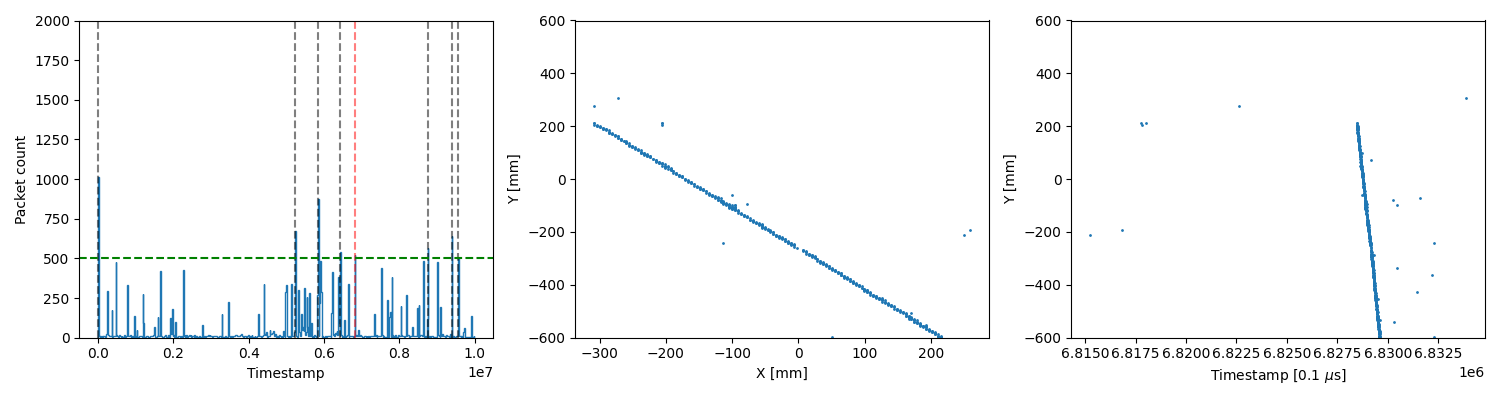

In [16]:
plot_events(10, 4, threshold=500)

23827  data packets between syncs
8  candidate events
524  hits in event
[-104.199 -104.199 -104.199 -104.199 -104.199 -104.199 -104.199 -104.199] [ -95.331  -99.765 -104.199 -108.633  -99.765 -104.199  -99.765 -104.199]


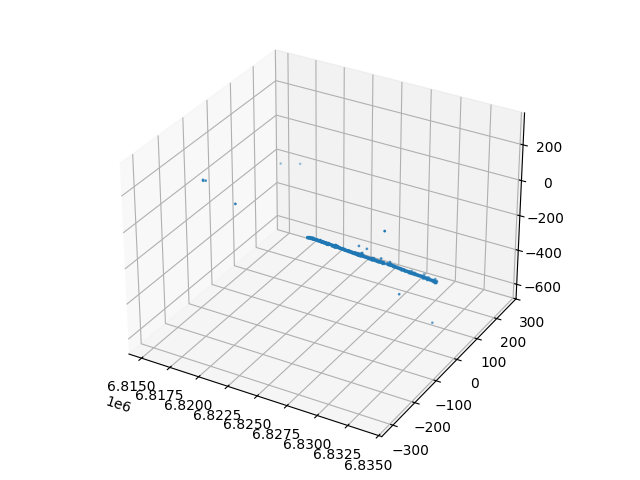

In [17]:
plot_events_3d(10, 4, threshold=500)

23827  data packets between syncs
8  candidate events
524  hits in event
1
[66]
23827  data packets between syncs
8  candidate events
524  hits in event
1
[66]
1
[66]


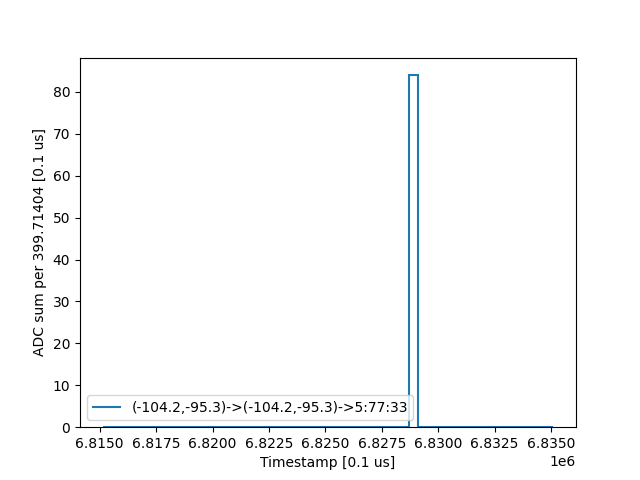

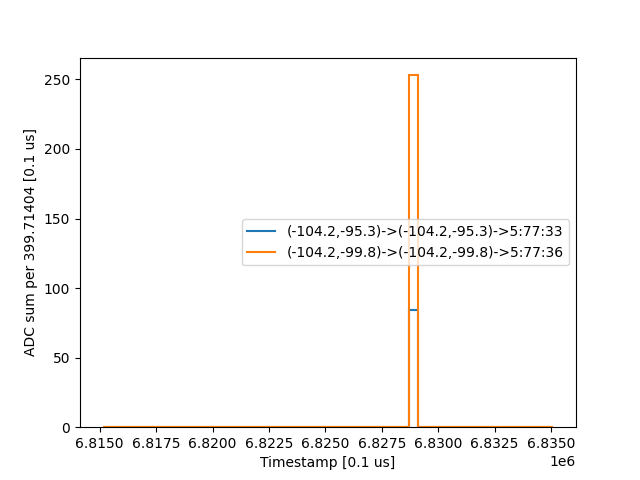

In [38]:
plot_adc(10, 4, -104.199, -95.331, threshold=500)

plot_adc(10, 4, [-104.199, -104.199], [-95.331, -99.765], threshold=500)

23827  data packets between syncs
8  candidate events
524  hits in event
[66]
[66]
[66]
[66]


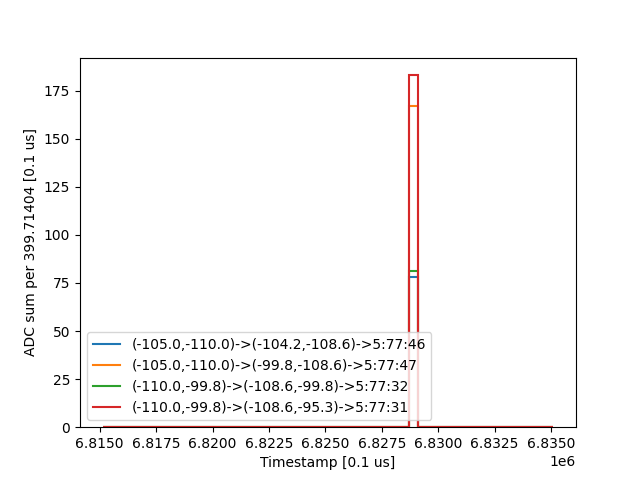

In [43]:
plot_adc(10, 4, [-105, -110], [-110, -99.765], threshold=500, k=2)